In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm
from scipy.sparse import csr_matrix

from sim_modules.testfuncs import gen_in_out_one_in_subs

import time

plt.ion()

In [246]:
N = 300
sigm_w = 1.
sigm_w_in = 1.

cf = 0.1
cf_in = 1.

dim_in = 1
dim_out = 1

T_sim = 200000

T_batch_w_out = N*5
reg_fact = 0.01

tau_task = 5

eps_a_r = 0.
eps_a_e = 0.
eps_w_out = 0.002
eps_w_out_batch = 1.


beta_V = 0.9
beta_S = 0.999
eps_adam = 10.**-8.

In [247]:
### recording
T_skip_rec = 500
T_rec = int(T_sim/T_skip_rec)

y_rec = np.ndarray((T_rec,N))
X_r_rec = np.ndarray((T_rec,N))
X_e_rec = np.ndarray((T_rec,N))

a_r_rec = np.ndarray((T_rec,N))
a_e_rec = np.ndarray((T_rec,N))

dyda_r_rec = np.ndarray((T_rec,N))
dyda_e_rec = np.ndarray((T_rec,N))

O_rec = np.ndarray((T_rec,dim_out))
err_rec = np.ndarray((T_rec,dim_out))

delta_a_r_rec = np.ndarray((T_rec,N))
delta_a_e_rec = np.ndarray((T_rec,N))

delta_w_out_rec = np.ndarray((T_rec,dim_out,N+1))
w_out_rec = np.ndarray((T_rec,dim_out,N+1))

In [248]:
## init
W = np.random.normal(0.,sigm_w/(N*cf)**.5,(N,N))*(np.random.rand(N,N) <= cf)
W[range(N),range(N)] = 0.

W_sp = csr_matrix(W)

W_t = np.array(W)

w_in = np.random.normal(0.,sigm_w_in,(N,dim_in))
w_out = (np.random.rand(dim_out,N+1)-.5)*0.1

#w_err_bp = np.array(w_out)
#w_err_bp = np.random.rand(dim_out,N+1)-.5
w_err_bp = np.ones((dim_out,N+1))

'''
a_r = .9
a_e = .2
'''
a_r = .9 * np.ones((N))
a_e = .2 * np.ones((N))


y = np.random.rand(N+1)-.5
y[0] = 1.

X = np.ndarray((N))
X_r = np.ndarray((N))
X_e = np.ndarray((N))

dy = np.ndarray((N))

dyda_r = np.zeros((N))
dyda_e = np.zeros((N))

'''
delta_a_r = 0.
delta_a_e = 0.
'''
delta_a_r = np.zeros((N))
delta_a_e = np.zeros((N))


delta_w_out = np.ndarray((dim_out,N+1))

u_in,u_out = gen_in_out_one_in_subs(T_sim,tau_task)
u_in = np.array([u_in])
u_out = np.array([u_out])

O = np.ndarray((dim_out))
err = np.ndarray((dim_out))

V_w_out = np.zeros((dim_out,N+1))
S_w_out = np.zeros((dim_out,N+1))

V_a_r = np.zeros((N))
S_a_r = np.zeros((N))

V_a_e = np.zeros((N))
S_a_e = np.zeros((N))

y_rec_w_out_learn = np.zeros((T_batch_w_out,N+1))
u_out_w_out_learn = np.zeros((T_batch_w_out,dim_out))

In [249]:
for t in tqdm(range(T_sim)):
    
    X_r[:] = W_sp.dot(y[1:])
    X_e[:] = w_in @ u_in[:,t]
    
    y[1:] = np.tanh(a_r*X_r + a_e*X_e)
    
    y_rec_w_out_learn[t%T_batch_w_out,:] = y[:]

    u_out_w_out_learn[t%T_batch_w_out,:] = u_out[:,t]
    
    O[:] = w_out @ y

    err[:] = O - u_out[:,t]

    dy[:] = 1.-y[1:]**2.

    #dyda_r[:] = dy * (X_r + a_r*(W_sp @ dyda_r))
    #dyda_e[:] = dy * (X_e + a_r*(W_sp @ dyda_e))
    
    dyda_r[:] = dy * X_r
    dyda_e[:] = dy * X_e
    
    
    if t > 2*T_batch_w_out:
    
        #delta_a_r = -(err * (w_out[:,1:] @ dyda_r)).sum()
        #delta_a_e = -(err * (w_out[:,1:] @ dyda_e)).sum()
        
        
        #delta_a_r = -(err * (w_err_bp[:,1:] @ dyda_r)).sum()
        #delta_a_e = -(err * (w_err_bp[:,1:] @ dyda_e)).sum()
        
        #delta_a_r = - (w_out[:,1:].T @ err)*dyda_r
        #delta_a_e = - (w_out[:,1:].T @ err)*dyda_e
        
        delta_a_r = - (w_err_bp[:,1:].T @ err)*dyda_r
        delta_a_e = - (w_err_bp[:,1:].T @ err)*dyda_e
        
        #delta_a_r[:] = delta_a_r.mean()
        #delta_a_e[:] = delta_a_e.mean()
        
        V_a_r[:] = beta_V*V_a_r + (1.-beta_V)*delta_a_r
        S_a_r[:] = beta_S*S_a_r + (1.-beta_S)*delta_a_r**2.
        
        V_a_e[:] = beta_V*V_a_e + (1.-beta_V)*delta_a_e
        S_a_e[:] = beta_S*S_a_e + (1.-beta_S)*delta_a_e**2.
        
        a_r += eps_a_r * (V_a_r/(1.-beta_V**(t+1)))/((S_a_r/(1.-beta_S**(t+1)))**.5 + eps_adam)
        a_e += eps_a_e * (V_a_e/(1.-beta_V**(t+1)))/((S_a_e/(1.-beta_S**(t+1)))**.5 + eps_adam)
        
        #a_r += eps_a_r * delta_a_r
        #a_e += eps_a_e * delta_a_e

        a_r = np.maximum(a_r,0.01)
        a_e = np.maximum(a_e,0.01)
    
    #'''
    delta_w_out[:,:] = -np.outer(err,y)
    
    V_w_out[:,:] = beta_V*V_w_out + (1.-beta_V)*delta_w_out
    S_w_out[:,:] = beta_S*S_w_out + (1.-beta_S)*delta_w_out**2.
    
    w_out += eps_w_out * (V_w_out/(1.-beta_V**(t+1)))/((S_w_out/(1.-beta_S**(t+1)))**.5 + eps_adam)
    w_out[:,1:] = np.maximum(0.,w_out[:,1:])
    #'''
    #'''
    if t==T_batch_w_out:
        
        w_out[:,:] = w_out*(1.-eps_w_out_batch) + eps_w_out_batch*(np.linalg.inv(y_rec_w_out_learn.T @ y_rec_w_out_learn + reg_fact*np.eye(N+1)) @ y_rec_w_out_learn.T @ u_out_w_out_learn).T
        w_out[:,1:] = np.maximum(0.,w_out[:,1:])
    #'''
    
    ### recording
    if t%T_skip_rec == 0:
        t_rec = int(t/T_skip_rec)
        
        y_rec[t_rec,:] = y[1:]
        X_r_rec[t_rec,:] = X_r
        X_e_rec[t_rec,:] = X_e
        
        O_rec[t_rec,:] = O
        err_rec[t_rec,:] = err
        
        dyda_r_rec[t_rec,:] = dyda_r
        dyda_e_rec[t_rec,:] = dyda_e
        
        delta_a_r_rec[t_rec,:] = delta_a_r
        delta_a_e_rec[t_rec,:] = delta_a_e
        
        a_r_rec[t_rec,:] = a_r
        a_e_rec[t_rec,:] = a_e
        
        delta_w_out_rec[t_rec,:,:] = delta_w_out
        w_out_rec[t_rec,:,:] = w_out

L_rec = 0.5*(err_rec**2.).sum(axis=1)

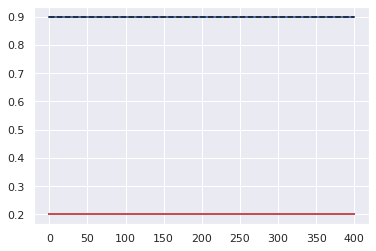

In [250]:
plt.plot(a_r_rec[:,:50],c='b')
plt.plot(((a_r_rec**2.).sum(axis=1)/N)**.5,'--',c='k')
plt.plot(a_e_rec[:,:10],c='r')

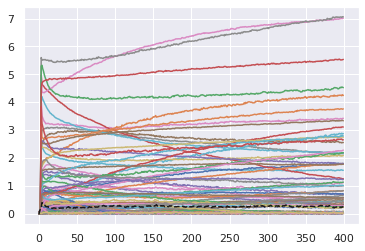

In [251]:
plt.plot(w_out_rec[:,0,1:100])
plt.plot(w_out_rec[:,0,0],'--',c='k')

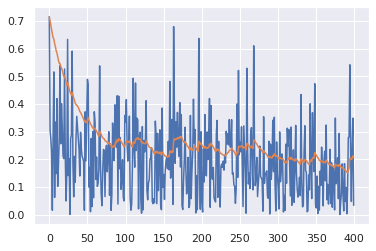

In [252]:
L_filt = np.ndarray((T_rec))
L_filt[0] = L_rec[0]
for t in range(1,T_rec):
    L_filt[t] = L_filt[t-1]*0.95 + 0.05*L_rec[t]
    
plt.plot(L_rec**.5)
plt.plot(L_filt**.5)

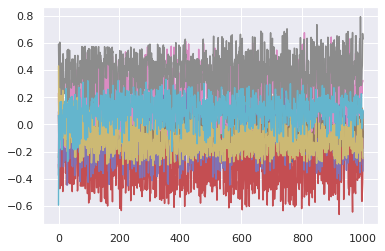

In [128]:
plt.plot(dyda_r_rec[:,:10])

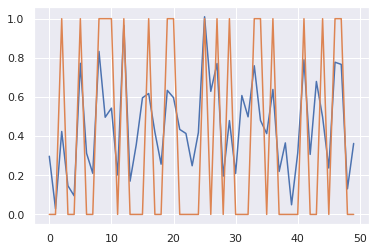

In [238]:
plt.plot(O_rec[-50:,:])
plt.plot(u_out[:,-50*T_skip_rec::T_skip_rec].T)

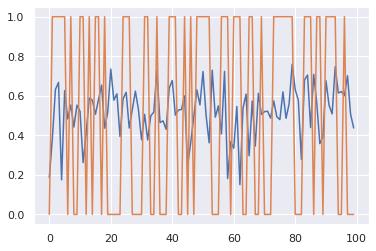

In [239]:
plt.plot(O_rec[:100,:])
plt.plot(u_out[:,:100].T)

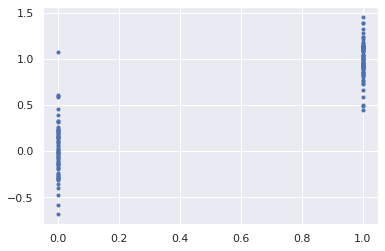

In [184]:
plt.plot(u_out[0,-150*T_skip_rec::T_skip_rec].T,O_rec[-150:,0],'.')